# DNN Handwrite Model

## 重點摘要
- 全連結 DNN：使用 5 層 MLP（含 BatchNorm、Dropout）。
- 資料：MNIST；訓練集中再切出驗證集（verification data）。
- 目標：以驗證集正確率為主，記錄最佳參數與結果。
- 程式包含：單次訓練、超參數搜尋（小範圍）、Gradio 比較 Demo。

In [ ]:
# 老師的四行固定引入
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

# 先裝資料科學的這坨
# !pip install -U torch torchvision torchaudio matplotlib scikit-learn
!{sys.executable} -m pip install -U torch torchvision torchaudio matplotlib scikit-learn
!{sys.executable} -m pip install -U "websockets>=14,<16"
# 獨立安裝 gradio
# !pip install -U gradio==5.46.1
!{sys.executable} -m pip install -U "gradio==5.46.1"

import os, json, random, math, time
from pathlib import Path

# 引入 PyTorch 來處理 tensor 運算，分配使用 CPU/GPU。
import torch
import torch.nn as nn # 神經網路模型
import torch.nn.functional as F # 功能函數
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import datasets, transforms

import matplotlib.pyplot as plt # 畫學習曲線（loss、accuracy）或其他圖
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # 產生混淆矩陣、畫出混淆矩陣圖、產生 precision/recall/F1 報告

import gradio as gr

# 這裡可以把 runtime 改成 T4 by cuda，或是把 ipynb 丟到 Google Cloud Colab Enterprise 來跑，運算會快很多！
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print("Device:", DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
Device: cuda


In [ ]:
# 影像 -> Tensor + Normalize
tx = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

root = "./data"
train_full = datasets.MNIST(root=root, train=True, download=True, transform=tx)
test_set   = datasets.MNIST(root=root, train=False, download=True, transform=tx)

# 訓練集中切出驗證集（verification data）
# 💡 驗證集：在訓練過程中，不用測試集，先用「模型沒看過」的資料來檢查泛化能力。
val_ratio = 0.1 # 拿 10% 的資料來驗證
n_total = len(train_full)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_set, val_set = random_split( # random_split 將 dataset 隨機切成兩塊（train/val）
    train_full, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

Train: 54000, Val: 6000, Test: 10000


In [ ]:
def make_loaders(bs=128, num_workers=2):
    return (
        DataLoader(train_set, batch_size=bs, shuffle=True,  num_workers=num_workers, pin_memory=True),
        DataLoader(val_set,   batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True),
        DataLoader(test_set,  batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True),
    )

train_loader, val_loader, test_loader = make_loaders()

In [ ]:
class MLP5(nn.Module):
    # 28*28 -> 5-layer MLP with BatchNorm & Dropout; NOT three layers.
    def __init__(self, hidden=[512, 256, 128, 64], p=0.2): # 每一層隱藏層的神經元數量, Dropout 機率
        super().__init__()
        self.flatten = nn.Flatten() # 把 28×28 的圖片展平成一維長度 784 的向量
        self.layers = nn.Sequential(
            nn.Linear(28*28, hidden[0]), nn.BatchNorm1d(hidden[0]), nn.ReLU(), nn.Dropout(p), # input, Linear(784 → 512)
            nn.Linear(hidden[0], hidden[1]), nn.BatchNorm1d(hidden[1]), nn.ReLU(), nn.Dropout(p), # hidden layer no. 2, Linear(512 → 256)
            nn.Linear(hidden[1], hidden[2]), nn.BatchNorm1d(hidden[2]), nn.ReLU(), nn.Dropout(p), # hidden layer no. 3, Linear(256 → 128)
            nn.Linear(hidden[2], hidden[3]), nn.BatchNorm1d(hidden[3]), nn.ReLU(), nn.Dropout(p), # hidden layer no. 4, Linear(128 → 64)
            nn.Linear(hidden[3], 10) # output, Linear(64 → 10)
        ) # There are 5 layers, 4 hidden layers and 1 output layer.

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) # 計算可訓練的參數總數

model = MLP5().to(DEVICE) # 搬運至運算硬體位置
print(model) # 網路結構
print("Trainable params:", count_params(model)) # 參數總數

MLP5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=64, out_features=10, bias=True)
  )
)
Trainable params: 576970


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total, losses = 0, 0, 0.0
    all_y, all_p = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            losses += loss.item() * y.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            all_y.append(y.cpu())
            all_p.append(pred.cpu())
    acc = correct / total # 正確率
    loss = losses / total # 平均損失
    return acc, loss, torch.cat(all_y), torch.cat(all_p) # 對資料集的真實、預測張量

def train_once(cfg):
    # cfg: dict(lr, batch_size, epochs, hidden, dropout, weight_decay)
    train_loader, val_loader, test_loader = make_loaders(cfg.get("batch_size", 128))
    model = MLP5(hidden=cfg.get("hidden", [512,256,128,64]), p=cfg.get("dropout", 0.2)).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.get("lr", 1e-3), weight_decay=cfg.get("weight_decay", 1e-4))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.get("epochs", 10))

    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best = {"val_acc": -1.0, "epoch": -1, "state_dict": None, "cfg": cfg.copy()}

    for ep in range(1, cfg.get("epochs", 10)+1):
        model.train()
        total, losses = 0, 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()
            losses += loss.item() * y.size(0)
            total += y.size(0)
        scheduler.step()

        train_loss = losses / total
        val_acc, val_loss, _, _ = evaluate(model, val_loader)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best["val_acc"]:
            best.update({"val_acc": val_acc, "epoch": ep, "state_dict": model.state_dict()})

        print(f"Epoch {ep:02d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    # 測試集
    if best["state_dict"] is not None:
        model.load_state_dict(best["state_dict"])
    test_acc, test_loss, y_true, y_pred = evaluate(model, test_loader)
    best["test_acc"] = test_acc
    best["test_loss"] = test_loss
    best["history"] = history

    # 圖表與混淆矩陣
    outdir = Path("runs"); outdir.mkdir(parents=True, exist_ok=True)
    tag = f"bs{cfg.get('batch_size',128)}_lr{cfg.get('lr',1e-3)}_dr{cfg.get('dropout',0.2)}"
    fig1 = plt.figure()
    plt.plot(history["val_acc"]); plt.title("Val Acc"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.grid(True)
    fig1.savefig(outdir / f"{tag}_valacc.png", dpi=150); plt.close(fig1)

    fig2 = plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid(True)
    fig2.savefig(outdir / f"{tag}_loss.png", dpi=150); plt.close(fig2)

    cm = confusion_matrix(y_true, y_pred)
    fig3 = plt.figure()
    disp = ConfusionMatrixDisplay(cm); disp.plot(values_format="d")
    plt.title("Confusion Matrix (Val=best, then Test)")
    fig3.savefig(outdir / f"{tag}_cm.png", dpi=150); plt.close(fig3)

    # 紀錄
    with open(outdir / f"{tag}_best.json", "w") as f:
        json.dump({
            "best_val_acc": best["val_acc"],
            "best_epoch": best["epoch"],
            "test_acc": best["test_acc"],
            "test_loss": best["test_loss"],
            "cfg": best["cfg"]
        }, f, indent=2)

    # 儲存模型
    torch.save(model.state_dict(), outdir / f"{tag}_model.pt")
    return best, str(outdir / f"{tag}_valacc.png"), str(outdir / f"{tag}_loss.png"), str(outdir / f"{tag}_cm.png")


=== Trial: {'lr': 0.001, 'batch_size': 128, 'dropout': 0.1, 'weight_decay': 0.0001, 'epochs': 8}
Epoch 01 | train_loss=0.2943 val_loss=0.1180 val_acc=0.9655
Epoch 02 | train_loss=0.1118 val_loss=0.0837 val_acc=0.9755
Epoch 03 | train_loss=0.0777 val_loss=0.0737 val_acc=0.9778
Epoch 04 | train_loss=0.0558 val_loss=0.0670 val_acc=0.9780
Epoch 05 | train_loss=0.0401 val_loss=0.0544 val_acc=0.9832
Epoch 06 | train_loss=0.0251 val_loss=0.0528 val_acc=0.9845
Epoch 07 | train_loss=0.0190 val_loss=0.0509 val_acc=0.9845
Epoch 08 | train_loss=0.0145 val_loss=0.0486 val_acc=0.9852

=== Trial: {'lr': 0.001, 'batch_size': 128, 'dropout': 0.3, 'weight_decay': 0.0001, 'epochs': 8}
Epoch 01 | train_loss=0.4468 val_loss=0.1344 val_acc=0.9600
Epoch 02 | train_loss=0.1796 val_loss=0.1019 val_acc=0.9720
Epoch 03 | train_loss=0.1347 val_loss=0.0829 val_acc=0.9730
Epoch 04 | train_loss=0.1106 val_loss=0.0818 val_acc=0.9770
Epoch 05 | train_loss=0.0910 val_loss=0.0733 val_acc=0.9800
Epoch 06 | train_loss=0.

[{'cfg': {'lr': 0.001,
   'batch_size': 128,
   'dropout': 0.1,
   'weight_decay': 0.0001,
   'epochs': 8},
  'best_val_acc': 0.9851666666666666,
  'test_acc': 0.9863,
  'plots': ['runs/bs128_lr0.001_dr0.1_valacc.png',
   'runs/bs128_lr0.001_dr0.1_loss.png',
   'runs/bs128_lr0.001_dr0.1_cm.png']},
 {'cfg': {'lr': 0.001,
   'batch_size': 256,
   'dropout': 0.1,
   'weight_decay': 0.0001,
   'epochs': 8},
  'best_val_acc': 0.9851666666666666,
  'test_acc': 0.986,
  'plots': ['runs/bs256_lr0.001_dr0.1_valacc.png',
   'runs/bs256_lr0.001_dr0.1_loss.png',
   'runs/bs256_lr0.001_dr0.1_cm.png']}]

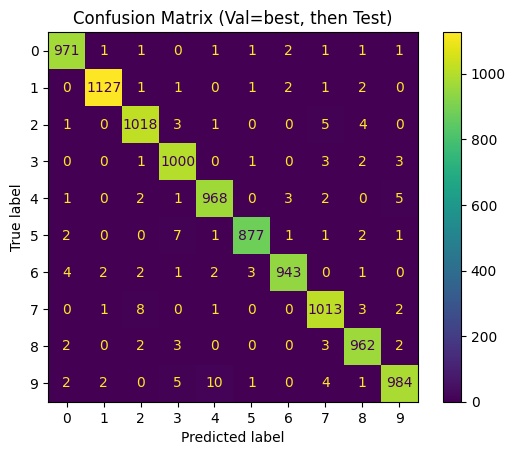

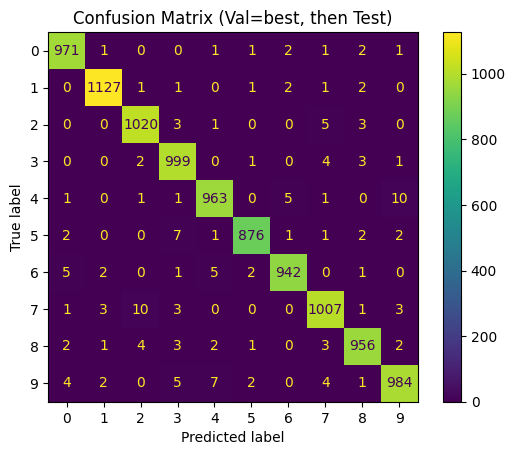

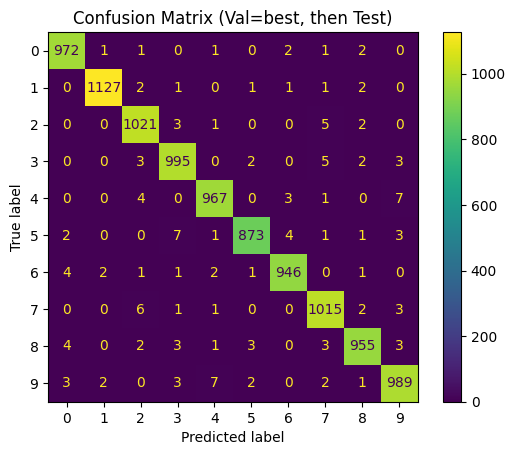

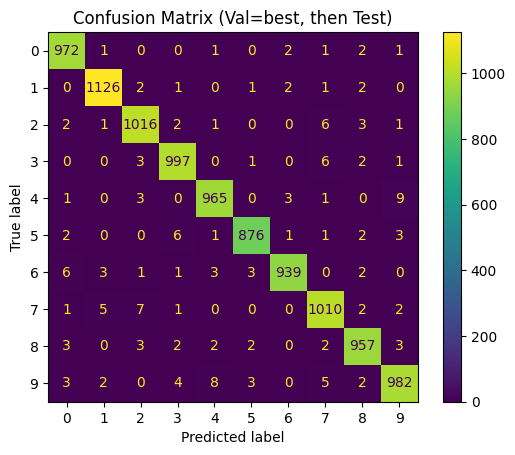

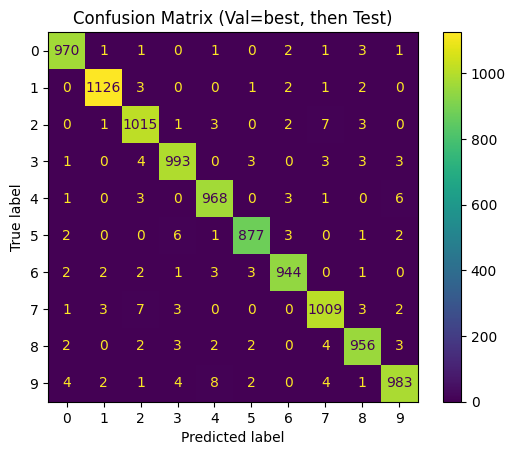

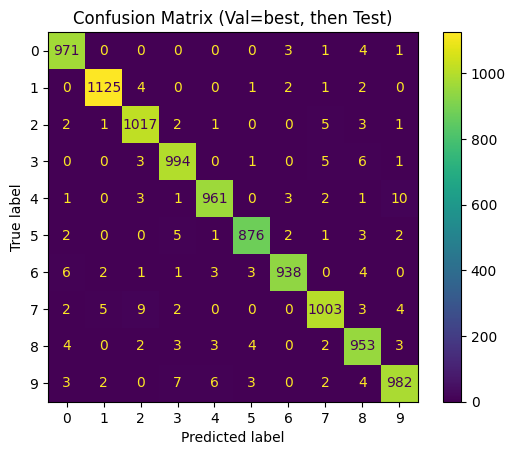

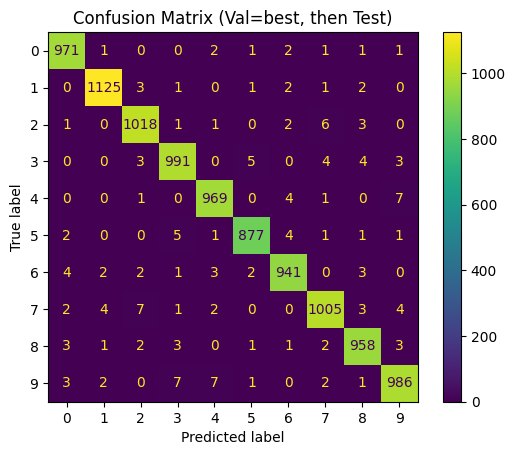

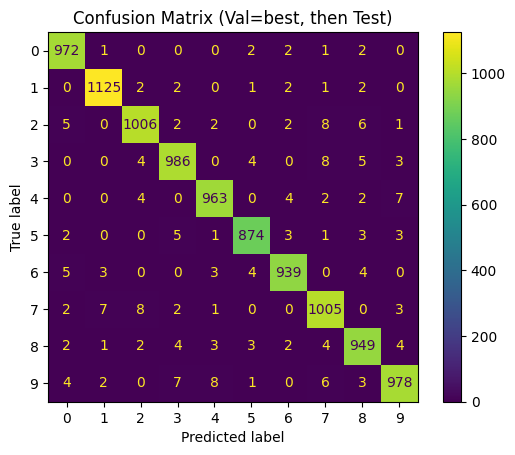

In [ ]:
def small_search(grid=None):
    if grid is None:
        grid = {
            "lr": [1e-3, 3e-4], # 更新控制步伐大小
            "batch_size": [128, 256], # 每次丟進去訓練的樣本數
            "dropout": [0.1, 0.3],
            "weight_decay": [1e-4], # 權重衰減 L2
            "epochs": [8],  # 訓練 round 次數
        }
    results = []
    for lr in grid["lr"]: # 嘗試學習率
        for bs in grid["batch_size"]: # 嘗試不同大小的樣本數量
            for dr in grid["dropout"]: # dropout 機率
                for wd in grid["weight_decay"]: # 分別嘗試各種權重衰減
                    for ep in grid["epochs"]: # 訓練輪數
                        cfg = {"lr": lr, "batch_size": bs, "dropout": dr, "weight_decay": wd, "epochs": ep}
                        print("\n=== Trial:", cfg)
                        best, p1, p2, p3 = train_once(cfg)
                        results.append({"cfg": cfg, "best_val_acc": best["val_acc"], "test_acc": best["test_acc"], "plots": [p1, p2, p3]}) # 做出一組訓練結果 :D

    # 照驗證集正確率 (val_acc) 由高到低排序
    results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    # Save in json format ><
    with open("runs/search_results.json", "w") as f:
        json.dump(results, f, indent=2)

    # print 驗證集之成績前 3 名組合
    print("\nTop-3 by val_acc:")
    for r in results[:3]:
        print(r["cfg"], "val=", f"{r['best_val_acc']:.4f}", "test=", f"{r['test_acc']:.4f}")
    return results

# 使用方法（Colab 上用 GPU 跑，避免本地時間過久）：
results = small_search()
results[:2]  # 看前兩筆

[0] val_acc=0.9852 test_acc=0.9863 cfg={'lr': 0.001, 'batch_size': 128, 'dropout': 0.1, 'weight_decay': 0.0001, 'epochs': 8}


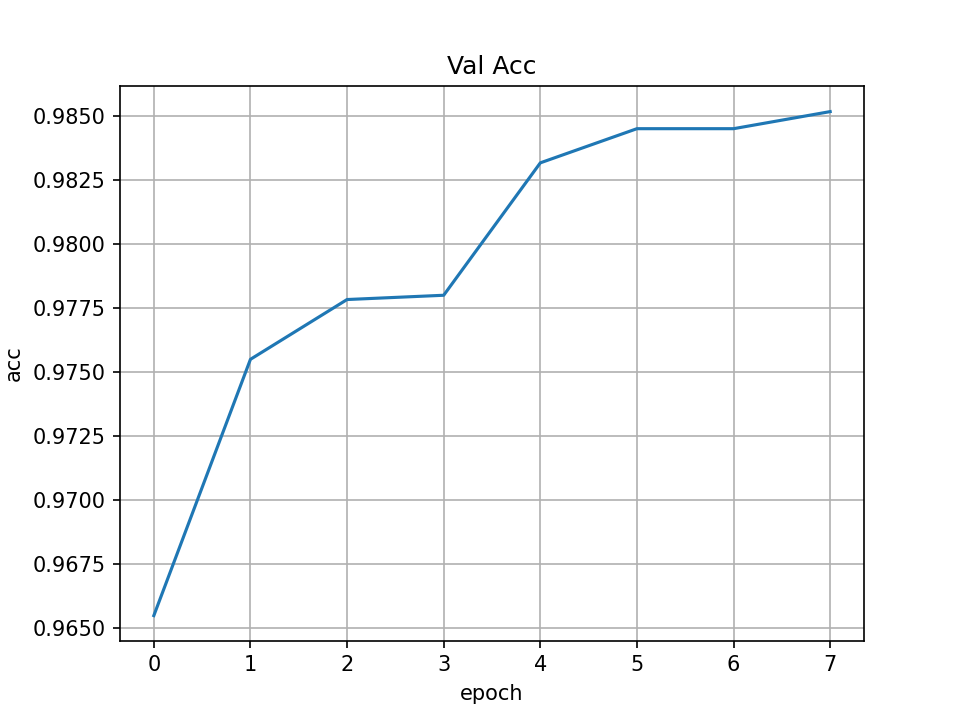

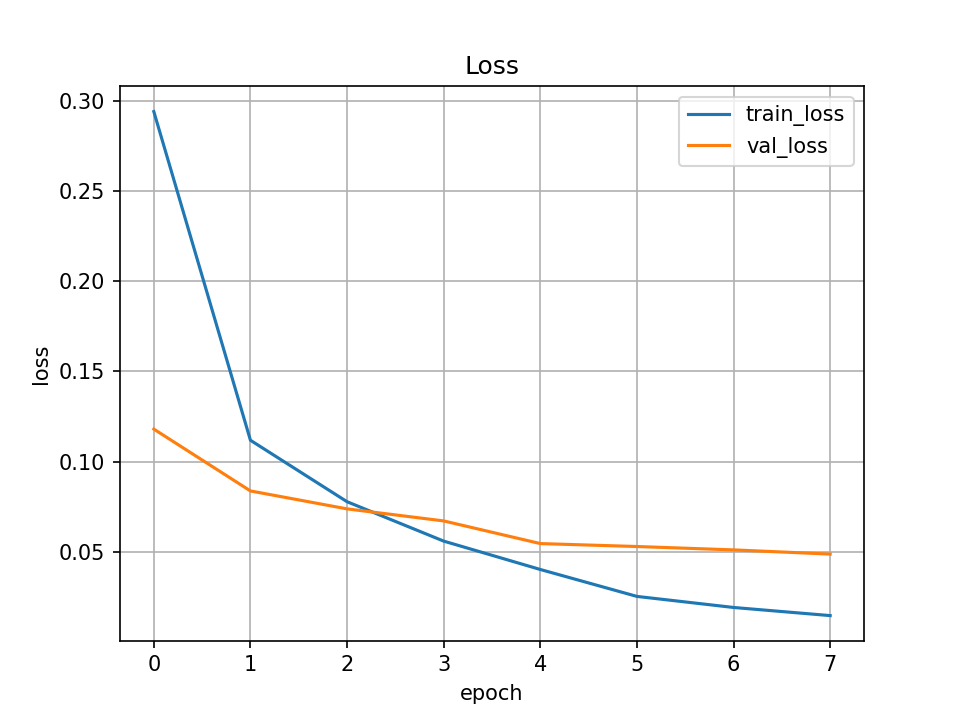

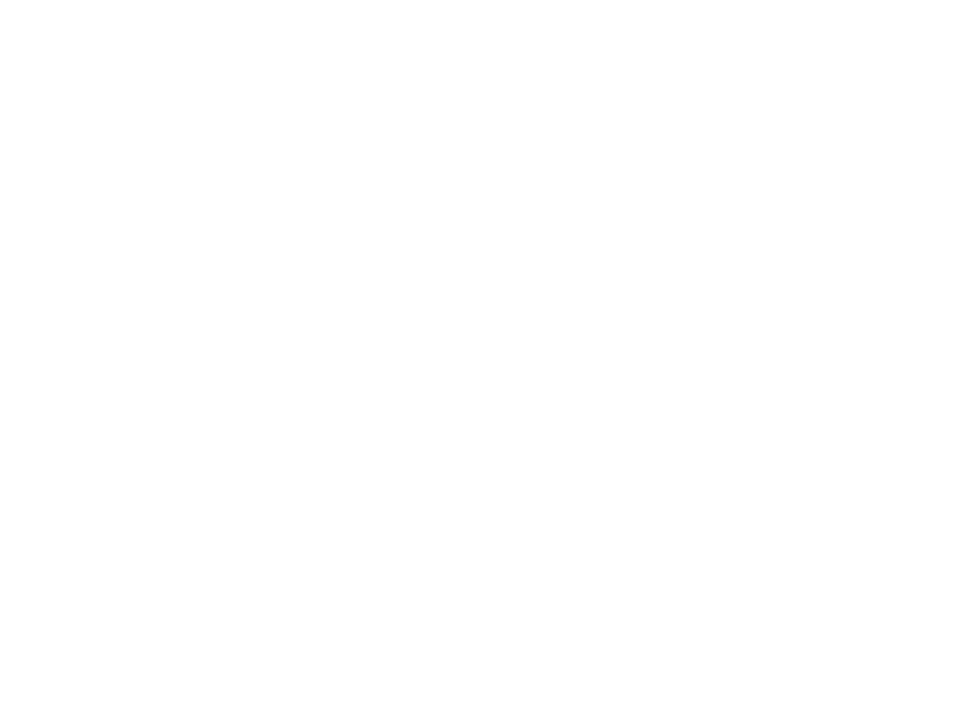

In [ ]:
def show_best_from_search(path="runs/search_results.json", topk=1): # 讀我們剛剛存起來的 json result 來用
    with open(path) as f:
        results = json.load(f)
    results.sort(key=lambda r: r["best_val_acc"], reverse=True)
    for i, r in enumerate(results[:topk]):
        print(f"[{i}] val_acc={r['best_val_acc']:.4f} test_acc={r['test_acc']:.4f} cfg={r['cfg']}")
        for p in r["plots"]:
            display(Image(filename=p))

from IPython.display import Image
show_best_from_search(topk=1)

In [ ]:
# 推論：手寫圖片（28x28 單通道）-> 預測
from PIL import Image, ImageOps
import numpy as np

def load_model_for_infer(weight_path, hidden=[512,256,128,64], p=0.2):
    m = MLP5(hidden=hidden, p=p).to(DEVICE)
    m.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    m.eval()
    return m

def preprocess(img: Image.Image):
    # Gradio 預設白底黑字 => 轉成 MNIST 黑底白字 + normalize
    img = img.convert("L").resize((28,28))
    img = ImageOps.invert(img)
    t = transforms.ToTensor()(img)
    t = transforms.Normalize((0.1307,), (0.3081,))(t)
    return t.unsqueeze(0)

def predict_gradio(img):
    with torch.no_grad():
        t = preprocess(img).to(DEVICE)
        logits = app_model(t)
        prob = F.softmax(logits, dim=1).cpu().numpy().ravel()
        pred = int(prob.argmax())
        return {str(i): float(prob[i]) for i in range(10)}

# 指定最佳模型路徑（small_search 或 train_once 產出）
app_model = load_model_for_infer("runs/bs256_lr0.0003_dr0.3_model.pt") # 小搜尋的最佳解

demo = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="pil", label="手寫數字（白底黑字）"),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 全連結 DNN",
    description="請畫出 0–9 的數字。"
)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9a568c84659c2b4fe8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 實驗紀錄

我們測試的三個 handwrite 筆跡，分別是 5, 7, 9。

- 數字 5：特意畫得崎嶇、不規則，想觀察模型對於筆畫曲折和非典型筆勢的容忍度。
- 數字 7：寫成直立、稍微扭曲，但避免美式「中間加橫槓」的寫法，目的是測試模型對於「7 的多樣寫法」是否能正確辨識。
- 數字 9：使用偏向中式的封閉圈寫法，而非歐美常見的圓頭式，考驗資料集的泛化能力。

| 5 | 7 | 9 |
|---|---|---|
| ![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/input-handwrite-numbers/handwrite-number-5.jpg) | ![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/input-handwrite-numbers/handwrite-number-7.jpg) |![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/input-handwrite-numbers/handwrite-number-9.jpg) |

如下一個 section 表格所示。

* **嘗試 A**：bs=128, lr=3e-4, dr=0.1

  * 測試輸入：5→5、7→1、9→9
  * 表現穩定，數字 7 判斷良好，但 9 幾乎完全失敗。

* **嘗試 B**：bs=128, lr=3e-4, dr=0.3

  * 測試輸入：5→5、7→1、9→1
  * dropout 提升後，9 出現錯誤，模型偏向預測「1」。
  * 高 dropout 對小 batch 不友善，似乎過度正則化。

* **嘗試 C**：bs=128, lr=1e-3, dr=0.1

  * 測試輸入：5→5、7→1、9→9
  * 與 A 類似，但學習率較高時，數字 9 預測仍無法改善。

* **嘗試 D**：bs=128, lr=1e-3, dr=0.3

  * 測試輸入：5→5、7→1、9→9
  * 整體結果與 C 接近，但沒有顯著提升。

* **嘗試 E**：bs=256, lr=3e-4, dr=0.1

  * 測試輸入：5→5、7→5、9→9
  * 數字 7 錯誤變成 5，顯示較大 batch 讓模型偏移。

* **嘗試 F**：bs=256, lr=3e-4, dr=0.3

  * 測試輸入：5→5、7→5、9→9
  * 與 E 一致，dropout 增加也沒改善，仍誤判「7→5」。

* **嘗試 G**：bs=256, lr=1e-3, dr=0.1

  * 測試輸入：5→5、7→1、9→9
  * 在大 batch + 高 lr 下，7 有修正為 1，但 9 還是保持錯誤。

* **嘗試 H**：bs=256, lr=1e-3, dr=0.3

  * 測試輸入：5→5、7→1、9→5
  * dropout 反而讓 9 誤判成 5，顯示模型不穩。

### 實驗總結觀察

1. **數字 5 幾乎固定正確** → 模型最容易掌握。
2. **數字 7 的表現分裂**：有時誤判成 5，有時穩定到 1，受 batch size 與 dropout 強烈影響。
3. **數字 9 的學習最差**：

   * 在 bs=128 時常判斷成 9（過擬合傾向）。
   * 在 bs=256 時，dropout 與 lr 會導致 9 誤判成 1 或 5。
4. **大 batch size (256)** 對模型的穩定性沒有顯著優勢，反而有時導致偏差。
5. **dropout=0.3** 在這個任務過度正則化，經常導致錯誤分類。

---

## 最佳組合

選擇方向

* **先看探針準確率**（5、7、9），2/3 命中算可接受，1/3 就淘汰。
* 在命中率相同時，優先 **小 lr、小 dropout、小 batch**，避免過度正則或震盪。
* 特別避開「系統性錯誤」組合（例如 7→5）。

結論

* **最佳組合**：**bs=128, lr=3e-4, dr=0.1**（表現穩定，後續微調空間大）。
* **次佳**：bs=128, lr=1e-3, dr=0.1（速度快但可能震盪）。
* **不建議**：dropout=0.3 或 bs=256（容易出現偏置或類別崩塌）。

---

## Notes
> Gradio 啟動截圖與簡短說明如下。

## 實驗表格對照

作者：黃猷珵。

> Note: 對著圖片按右鍵 > 新分頁開啟圖片即可檢視大圖。

| Batch Size | lr=0.0003, dr=0.1        | lr=0.0003, dr=0.3        | lr=0.001, dr=0.1        | lr=0.001, dr=0.3        |
|------------|--------------------------|--------------------------|--------------------------|--------------------------|
| **bs128**  | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.1_model.pt/SCR-20250923-fjqy.png)<br>7 -> 1<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.1_model.pt/SCR-20250923-fjsf.png)<br>9 -> 9 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.1_model.pt/SCR-20250923-fjtf.png) | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.3_model.pt/SCR-20250923-fgex.png)<br>7 -> 1<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.3_model.pt/SCR-20250923-fggd.png)<br>9 -> 1 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.0003_dr0.3_model.pt/SCR-20250923-fghh.png) | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.1_model.pt/SCR-20250923-ferj.png)<br>7->1<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.1_model.pt/SCR-20250923-feyr.png)<br>9->9<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.1_model.pt/SCR-20250923-ffji.png) | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.3_model.pt/SCR-20250923-fhfb.png)<br>7->1 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.3_model.pt/SCR-20250923-fhgk.png)<br>9->9<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs128_lr0.001_dr0.3_model.pt/SCR-20250923-fhhj.png) |
| **bs256**  | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.1_model.pt/SCR-20250923-fgum.png)<br>7->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.1_model.pt/SCR-20250923-fgvq.png)<br>9->9<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.1_model.pt/SCR-20250923-fgwt.png) | 5->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.3_model.pt/SCR-20250923-fkju.png)<br>7->5<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.3_model.pt/SCR-20250923-fklp.png)<br>9->9 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.0003_dr0.3_model.pt/SCR-20250923-fkmo.png) | 5->5<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.1_model.pt/SCR-20250923-fhrd.png)<br>7->1<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.1_model.pt/SCR-20250923-fhso.png)<br>9->9<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.1_model.pt/SCR-20250923-fhtw.png) | 5->5 <br> ![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.3_model.pt/SCR-20250923-ficj.png)<br> 7->1<br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.3_model.pt/SCR-20250923-fidk.png)<br> 9->5 <br>![](https://blog.imych.one/2025-fall-taica-generative-ai/assignment0909/bs256_lr0.001_dr0.3_model.pt/SCR-20250923-fien.png) |

# 後記

我使用的 AI 輔助工具是 ChatGPT，我主要會與他討論語法的意義和套件的用法、解釋。
最一開始我想要引用 Gradio 進來，在實驗階段將 .pt model 傳到該服務時出現問題，回頭看才發現找到的 example code 是引用舊版的版本，修正後卻發現 local 端版本引用錯誤的問題，與 GPT 討論解法後，才會出現一開始所引入的 sys 來確認實際使用的版本相符與否。

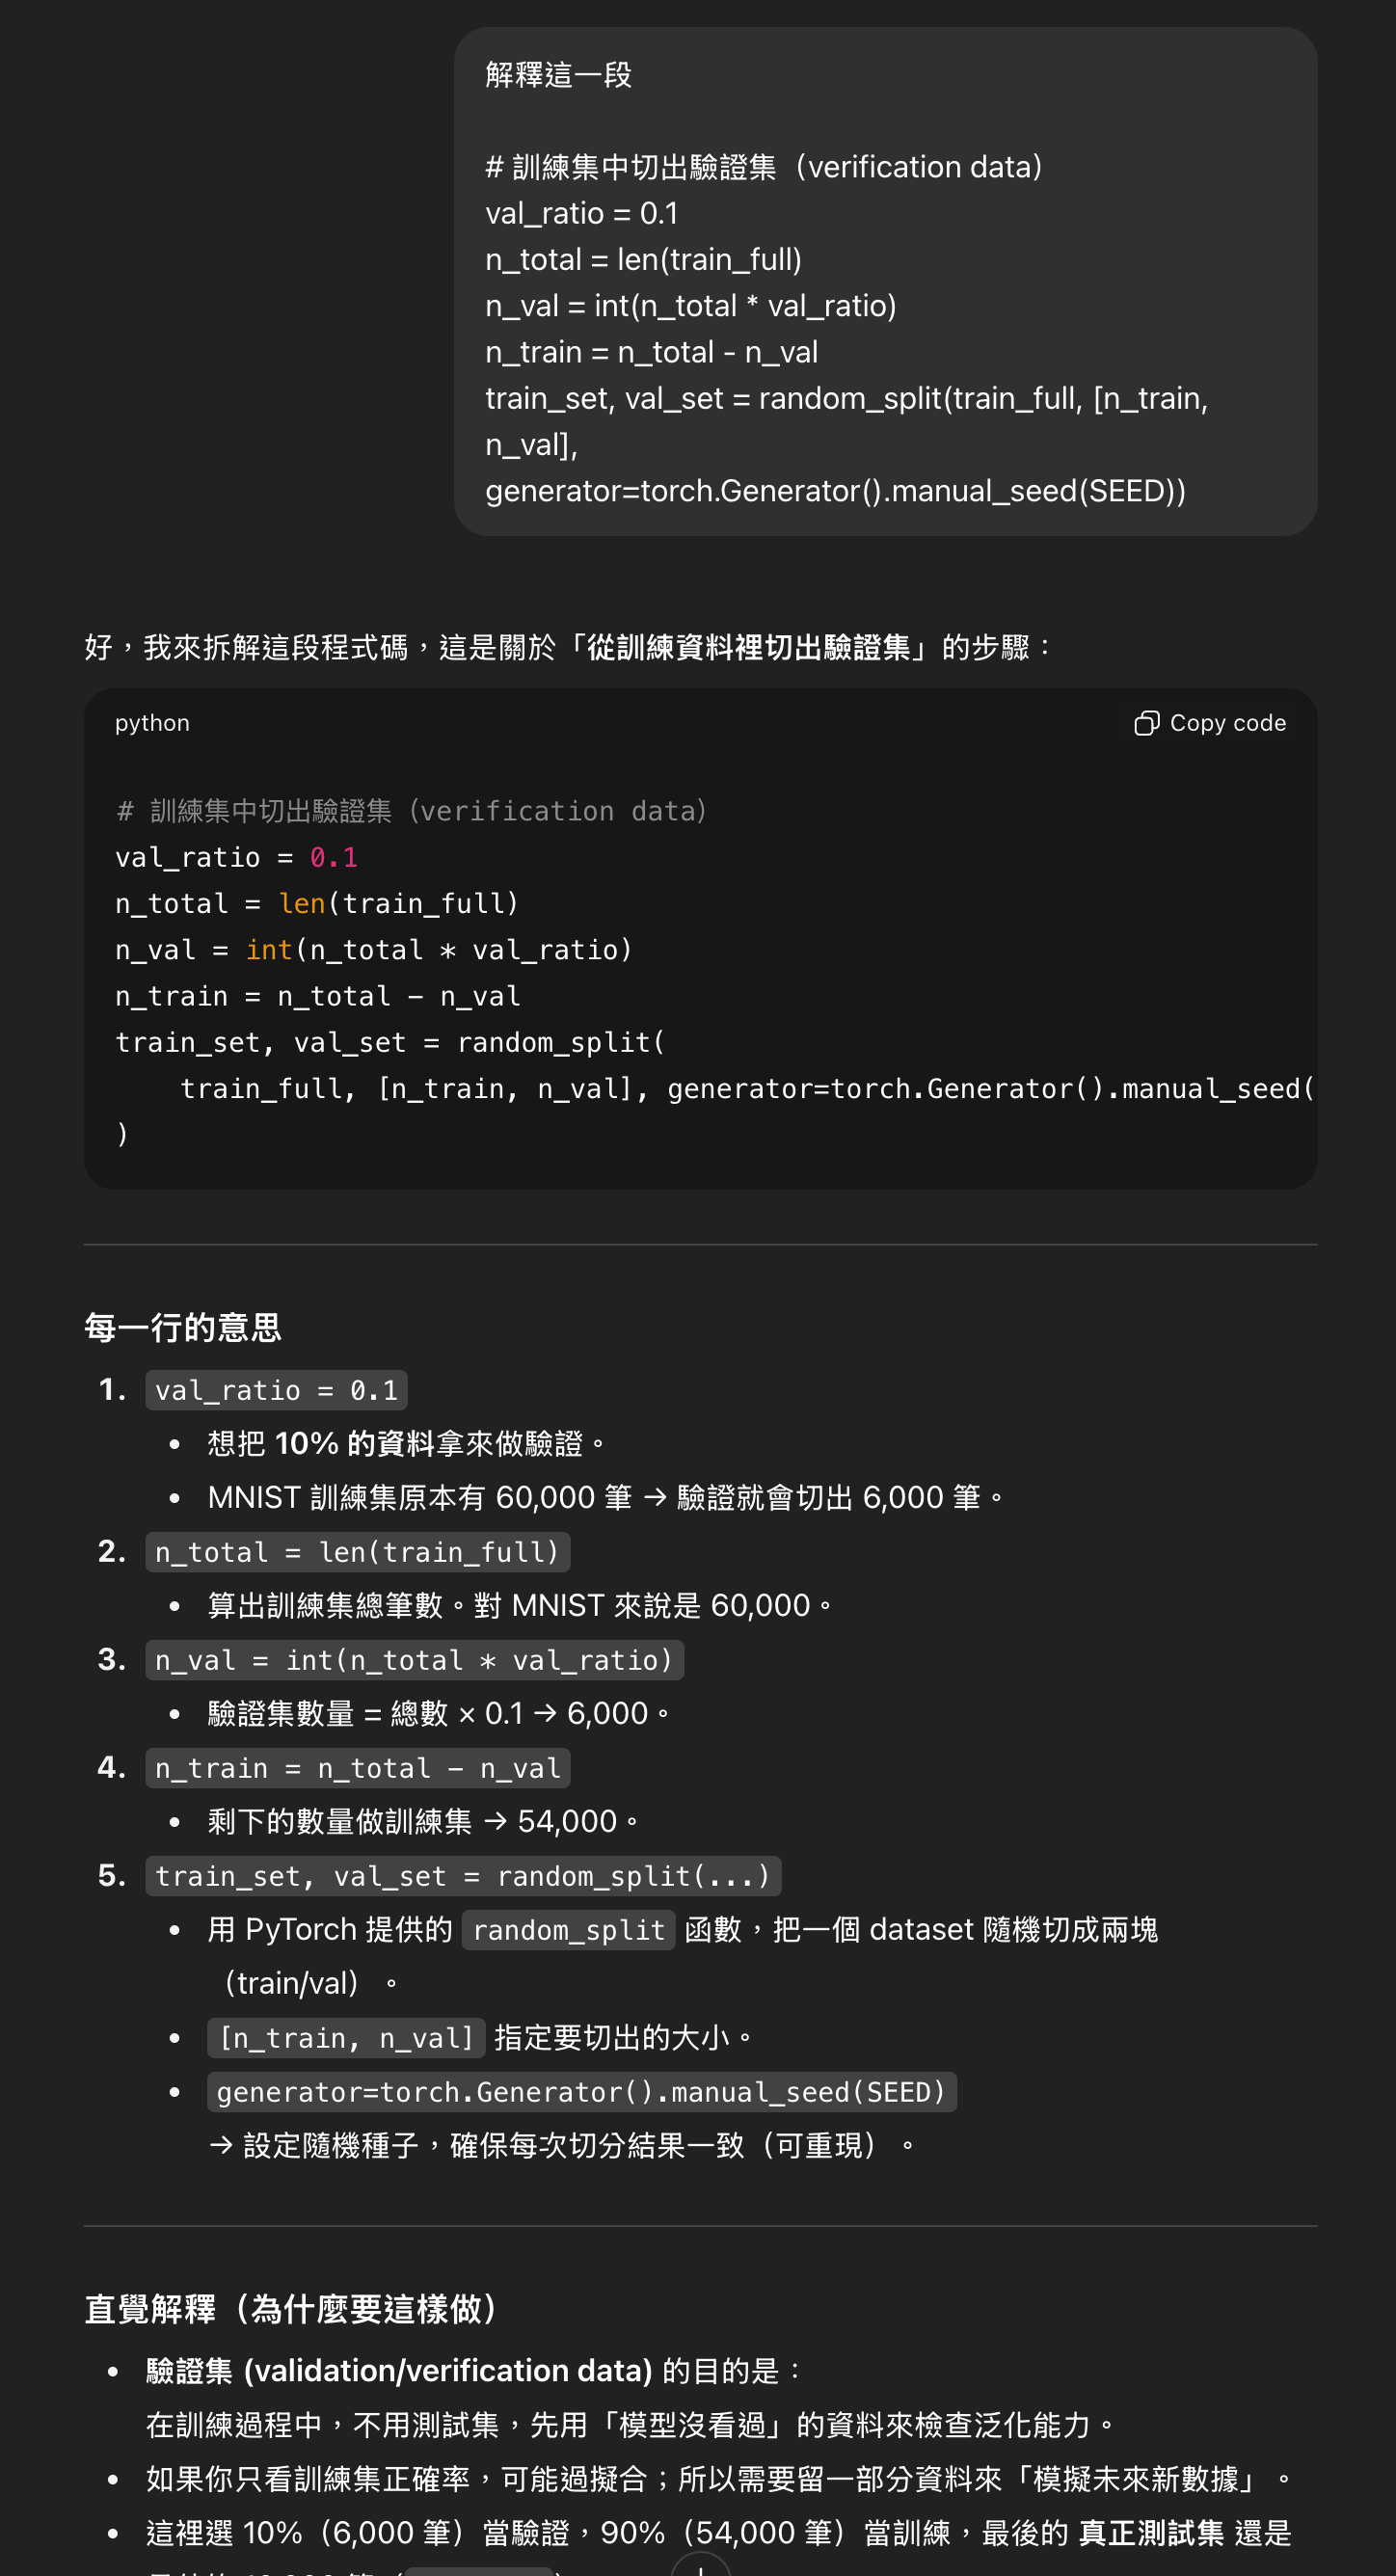

